# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud
import gzip
import itertools
import string
from sklearn.naive_bayes import MultinomialNB
import wordcloud
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pylab as pl
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve, auc

%matplotlib inline

In [2]:
#######Importing dataset########
dataset=pd.read_csv("./Data/Masterdata.csv")

In [3]:
########## For extracting stars value from complete ratings text#####
Review_stars=[]
for ratings in dataset['Ratings']:
    rate=ratings.split(" ")[0]
    Review_stars.append(rate)

dataset['Review_stars'] = Review_stars

In [4]:
dataset['Product full review']= dataset['Product full review'].values.astype('str')
dataset['text length'] =dataset['Product full review'].apply(len)

type(dataset['Product full review'])

pandas.core.series.Series

# Visualisation of Data

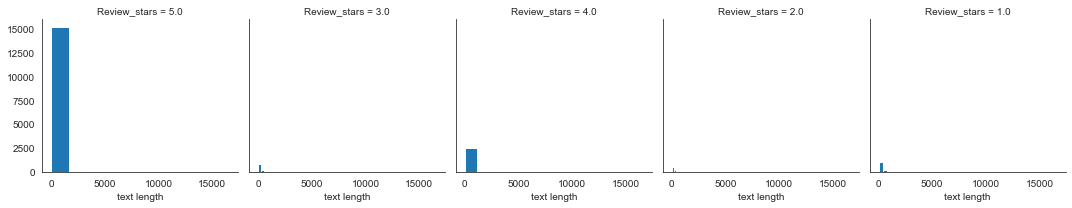

In [5]:
sns.set_style('white')
g = sns.FacetGrid(dataset,col='Review_stars')
g.map(plt.hist,'text length')

<AxesSubplot:xlabel='Review_stars', ylabel='text length'>

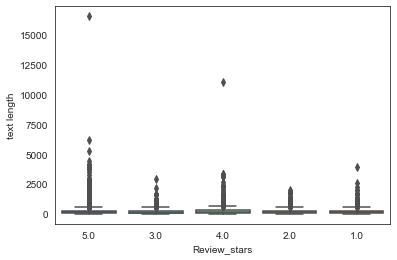

In [6]:
sns.boxplot(x='Review_stars',y='text length',data=dataset,palette='rainbow')

<AxesSubplot:xlabel='Review_stars', ylabel='count'>

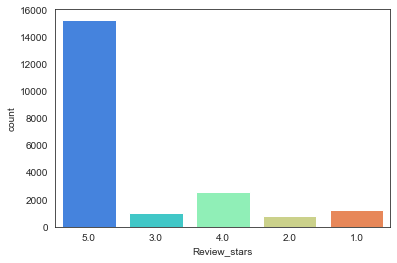

In [7]:
sns.countplot(x='Review_stars',data=dataset,palette='rainbow')

# Tokenization & Lemmatization

In [8]:
def tokenize(text):
    tokenized = word_tokenize(text)
    no_punc = []
    for review in tokenized:
        line = "".join(char for char in review if char not in string.punctuation)
        no_punc.append(line)
    tokens = lemmatize(no_punc)
    return [word for word in tokens if word.lower() not in stopwords.words('english')]


def lemmatize(tokens):
    lmtzr = WordNetLemmatizer()
    lemma = [lmtzr.lemmatize(t) for t in tokens]
    return lemma

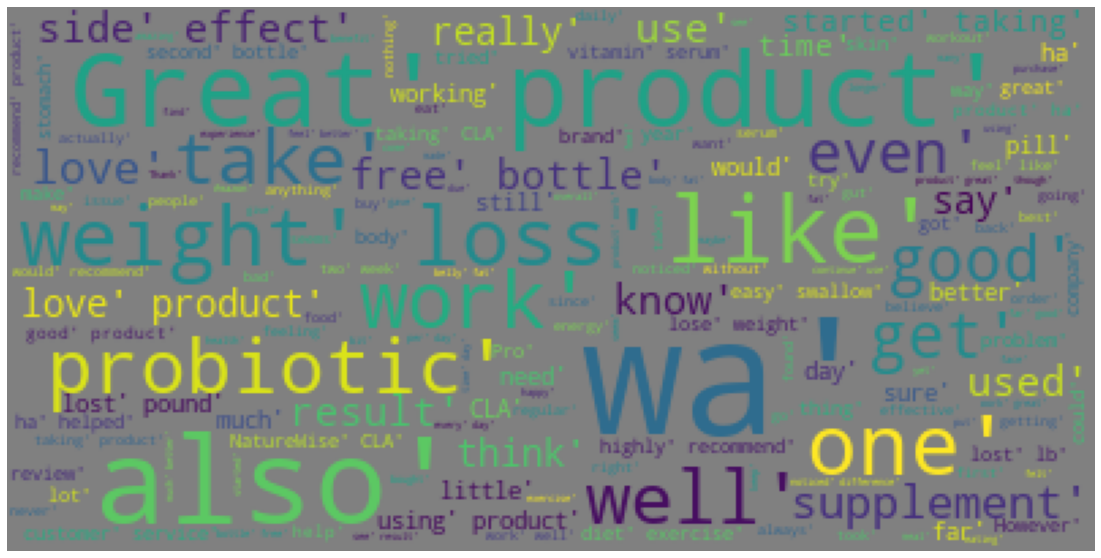

In [9]:
review_full=dataset["Product full review"]
review_full=review_full.apply(lambda x: tokenize(str(x)))
str_review_full=str(review_full)
s=[]

for i in review_full:
     str_review_full=str(i)
     s.append(str_review_full)
    
cloud = wordcloud.WordCloud(background_color='gray', max_font_size=60,relative_scaling=1).generate(' '.join(s))    
fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(cloud)

## Categorizing Reviews, 1-2 Stars Negative, 4-5 Stars Positive and 3 Stars Neutral (Removing Neutral Reviews)

In [10]:
int_ratings=[]

Review_stars    
type(Review_stars)    

new=[]
for y in Review_stars:
    if y=='5.0':
        z=5
        new.append(z)
    elif y=='4.0':
        z=4
        new.append(z)
    elif y=='3.0':
        z=3
        new.append(z)
    elif y=='2.0':
        z=2
        new.append(z)
    else :
        z=1
        new.append(z)
        
dataset["neg_or_pos"]=[1 if rate>3 else 0 for rate in new]

In [11]:
dataset['Review_stars']= pd.to_numeric(dataset['Review_stars'])
dataset = dataset[dataset.Review_stars != 3]

## Creating CountVectorizer & Removing Stop Words from our Dataset

In [12]:
tf_vectorizer = CountVectorizer(ngram_range=(1,2),stop_words = 'english')
model = tf_vectorizer.fit(dataset["Product full review"])


In [13]:
X = dataset['Product full review'].values.astype('str')
y= dataset['neg_or_pos']

### Creating Temp File to read it as chunk

In [14]:
Temp=pd.DataFrame({'Product Review summary':dataset['Product full review'],'neg_or_pos':dataset['neg_or_pos']})

In [16]:
Temp.to_csv('./Output/Temp.csv') 

In [17]:
#c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    
    clf = clf_model.partial_fit(X_train, y_train,classes=np.unique(y_train))
    acc.append(clf.score(X_test, y_test))
    print ('Model Accuracy: {}'.format(acc))
    
    return(model.get_feature_names(),clf.coef_.tolist()[0],clf2.predict(X_test),clf2.predict(X_train),y_train, y_test)

In [21]:
from sklearn.linear_model import LogisticRegression,SGDClassifier

acc=[]
k=1
clf2 = SGDClassifier(alpha=.0005,loss='log',penalty='l1',max_iter=5,eta0=0.01,learning_rate='optimal')
roc_auc_clf2 =[]
roc_auc_clf2_Train =[]
Length_of_Batch =[]

for i,chunk in enumerate(pd.read_csv("./Output/Temp.csv", chunksize=1111)):
    Length_of_Batch.append(len(chunk))
    chunk= chunk.dropna()
    X = chunk['Product Review summary'].values.astype('str')
    y= chunk['neg_or_pos']
    
    w,coef,TP2,TP_Train2,y_train, y_test = text_fit(X, y, model, clf2)
    if k ==1:
        
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        k= k+1
    else:
        df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df= coeff_df.append(df)
        
    # AUC Test
    FP2 = np.array(y_test)
    fpr2, tpr2,_ = roc_curve(FP2,TP2)
    roc_auc_clf2.append(auc(fpr2,tpr2))
    
    # AUC Train
    FP_Train2 = np.array(y_train)
    fpr2_train, tpr2_train,_ = roc_curve(FP_Train2,TP_Train2)
    roc_auc_clf2_Train.append(auc(fpr2_train,tpr2_train))

coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
coeff_df = coeff_df.drop_duplicates(subset=['Word'])

print('\n-Top 20 positive-')
print(coeff_df.head(20).to_string(index=False))

print('\n-Top 20 negative-')        
print(coeff_df.tail(20).to_string(index=False))

# features: 178778
# train records: 832
# test records: 278
Model Accuracy: [0.9028776978417267]
# features: 178778
# train records: 832
# test records: 278
Model Accuracy: [0.9028776978417267, 0.8633093525179856]
# features: 178778
# train records: 833
# test records: 278
Model Accuracy: [0.9028776978417267, 0.8633093525179856, 0.8884892086330936]
# features: 178778
# train records: 833
# test records: 278
Model Accuracy: [0.9028776978417267, 0.8633093525179856, 0.8884892086330936, 0.8884892086330936]
# features: 178778
# train records: 833
# test records: 278
Model Accuracy: [0.9028776978417267, 0.8633093525179856, 0.8884892086330936, 0.8884892086330936, 0.935251798561151]
# features: 178778
# train records: 833
# test records: 278
Model Accuracy: [0.9028776978417267, 0.8633093525179856, 0.8884892086330936, 0.8884892086330936, 0.935251798561151, 0.9100719424460432]
# features: 178778
# train records: 832
# test records: 278
Model Accuracy: [0.9028776978417267, 0.8633093525179856, 0.8

In [22]:
print(sum(acc)/len(acc))

0.92750190091829


In [23]:
nbatch = len(Length_of_Batch)
Total = sum(Length_of_Batch)

### AUC Curve for Test Results

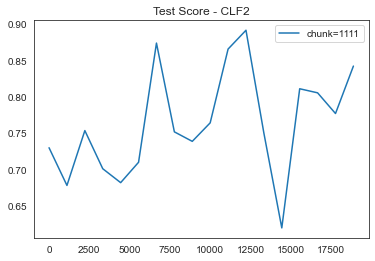

In [24]:
plt.plot(1111*np.arange(int(nbatch)),roc_auc_clf2,label='chunk=1111')
plt.title('Test Score - CLF2')
plt.legend()
plt.show()

### AUC Curve for Train Results

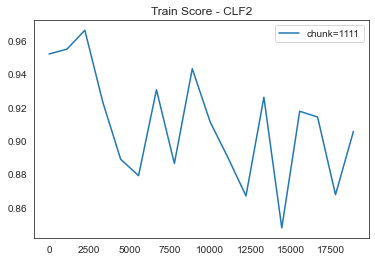

In [25]:
plt.plot(1111*np.arange(int(nbatch)),roc_auc_clf2_Train,label='chunk=1111')
plt.title('Train Score - CLF2')
plt.legend()
plt.show()

In [26]:
print('average_auc_clf2_test:')
print(sum(roc_auc_clf2)/len(roc_auc_clf2))
print('average_auc_clf2_train:')
print(sum(roc_auc_clf2_Train)/len(roc_auc_clf2_Train))

average_auc_clf2_test:
0.7632954348316686
average_auc_clf2_train:
0.9094961403641412


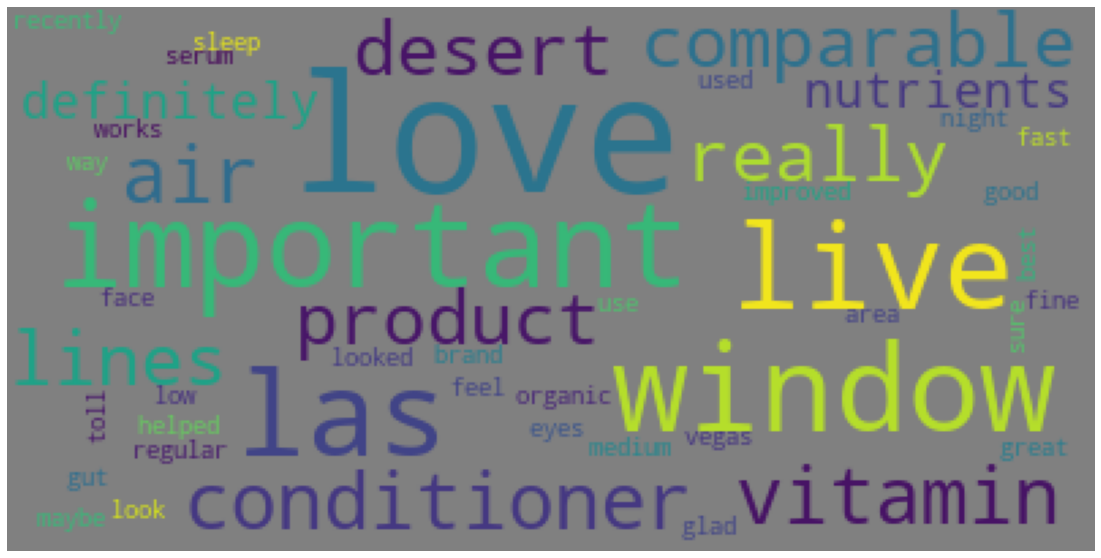

In [27]:
# Frequency of Most Words in Positive Review
s=[]
Positive_Words = coeff_df['Word'].head(50)

for i in Positive_Words:
     str_review_full=str(i)
     s.append(str_review_full)
    
cloud = wordcloud.WordCloud(background_color='gray', max_font_size=60,relative_scaling=1).generate(' '.join(s))    
fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(cloud);

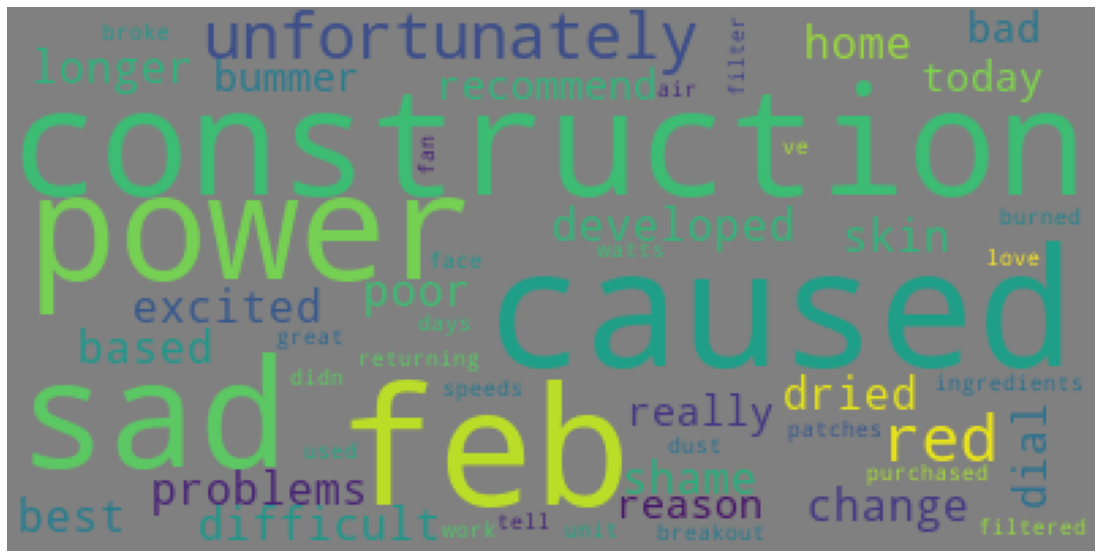

In [28]:
# Frequency of Most Words in Negative Review
s=[]
Negative_Words = coeff_df['Word'].tail(50)

for i in Negative_Words:
     str_review_full=str(i)
     s.append(str_review_full)
    
cloud = wordcloud.WordCloud(background_color='gray', max_font_size=60,relative_scaling=1).generate(' '.join(s))    
fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(cloud)

# Non- Linear Model

In [33]:
from sklearn.linear_model import LogisticRegression,SGDClassifier

acc=[]
k=1
clf2 = MultinomialNB()
roc_auc_clf2 =[]
roc_auc_clf2_Train =[]
Length_of_Batch =[]

for i,chunk in enumerate(pd.read_csv("./Output/Temp.csv", chunksize=1111)):
    Length_of_Batch.append(len(chunk))
    chunk= chunk.dropna()
    X = chunk['Product Review summary'].values.astype('str')
    y= chunk['neg_or_pos']
    
    w,coef,TP2,TP_Train2,y_train, y_test = text_fit(X, y, model, clf2)
    if k ==1:
        
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        k= k+1
    else:
        df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df= coeff_df.append(df)
        
    # AUC Test
    FP2 = np.array(y_test)
    fpr2, tpr2,_ = roc_curve(FP2,TP2)
    roc_auc_clf2.append(auc(fpr2,tpr2))
    
    # AUC Train
    FP_Train2 = np.array(y_train)
    fpr2_train, tpr2_train,_ = roc_curve(FP_Train2,TP_Train2)
    roc_auc_clf2_Train.append(auc(fpr2_train,tpr2_train))

coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
coeff_df = coeff_df.drop_duplicates(subset=['Word'])


print('\n-Top 20 positive-')
print(coeff_df.head(20).to_string(index=False))

print('\n-Top 20 negative-')        
print(coeff_df.tail(20).to_string(index=False))   

# features: 178778
# train records: 832
# test records: 278
Model Accuracy: [0.9532374100719424]
# features: 178778
# train records: 832
# test records: 278
Model Accuracy: [0.9532374100719424, 0.8525179856115108]
# features: 178778
# train records: 833
# test records: 278
Model Accuracy: [0.9532374100719424, 0.8525179856115108, 0.8812949640287769]
# features: 178778
# train records: 833
# test records: 278
Model Accuracy: [0.9532374100719424, 0.8525179856115108, 0.8812949640287769, 0.8812949640287769]
# features: 178778
# train records: 833
# test records: 278
Model Accuracy: [0.9532374100719424, 0.8525179856115108, 0.8812949640287769, 0.8812949640287769, 0.9136690647482014]
# features: 178778
# train records: 833
# test records: 278
Model Accuracy: [0.9532374100719424, 0.8525179856115108, 0.8812949640287769, 0.8812949640287769, 0.9136690647482014, 0.8920863309352518]
# features: 178778
# train records: 832
# test records: 278
Model Accuracy: [0.9532374100719424, 0.8525179856115108, 0

In [34]:
print(sum(acc)/len(acc))

0.9117843936233128


In [35]:
nbatch = len(Length_of_Batch)
Total = sum(Length_of_Batch)

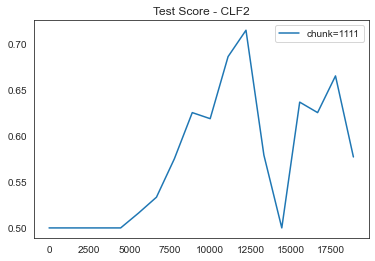

In [36]:
# AUC Curve for Test Results
plt.plot(1111*np.arange(int(nbatch)),roc_auc_clf2,label='chunk=1111')
plt.title('Test Score - CLF2')
plt.legend()
plt.show()

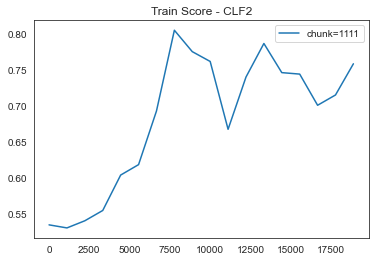

In [37]:
# AUC Curve for Train Results
plt.plot(1111*np.arange(int(nbatch)),roc_auc_clf2_Train,label='chunk=1111')
plt.title('Train Score - CLF2')
plt.legend()
plt.show()

In [38]:
print('average_auc_clf2_test:')
print(sum(roc_auc_clf2)/len(roc_auc_clf2))
print('average_auc_clf2_train:')
print(sum(roc_auc_clf2_Train)/len(roc_auc_clf2_Train))

average_auc_clf2_test:
0.5749892794171508
average_auc_clf2_train:
0.6812076876972017


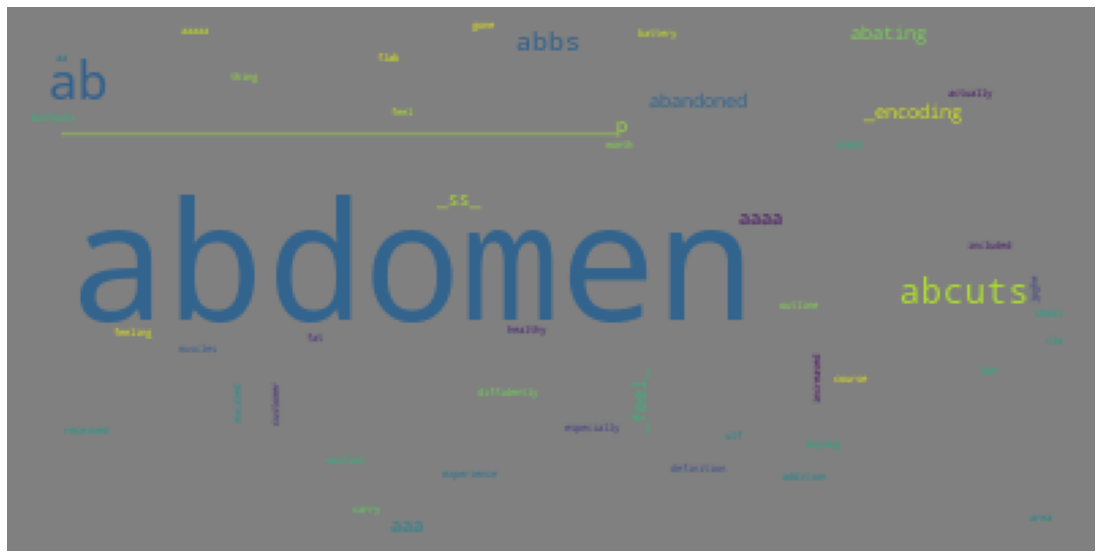

In [30]:
# Frequency of Most Words in Positive Review
s=[]
Positive_Words = coeff_df['Word'].head(50)

for i in Positive_Words:
     str_review_full=str(i)
     s.append(str_review_full)
    
cloud = wordcloud.WordCloud(background_color='gray', max_font_size=60,relative_scaling=1).generate(' '.join(s))    
fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(cloud)

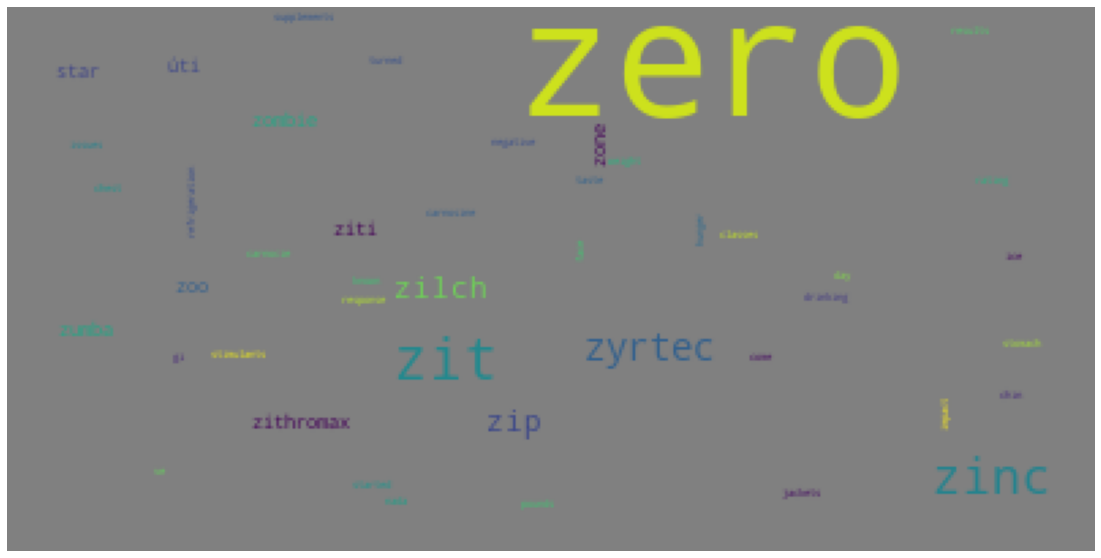

In [31]:
# Frequency of Most Words in Negative Review
s=[]
Negative_Words = coeff_df['Word'].tail(50)

for i in Negative_Words:
     str_review_full=str(i)
     s.append(str_review_full)
    
cloud = wordcloud.WordCloud(background_color='gray', max_font_size=60,relative_scaling=1).generate(' '.join(s))    
fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(cloud);